In [7]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import GradScaler, autocast
import tensorflow as tf
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight

import nlpaug.augmenter.word as naw
import random
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

sns.set(rc={'figure.figsize':(20,10)})

In [8]:
# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

print(train_data.head())

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

def model_summary(model):
    print("Model summary:")
    print("---------------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
    print(f"Total parameters: {total_params}")

                       id                                             lyrics  \
0  1FAmKoufyAXMfzPPs9bsjA  i tied my bandana took my pack from the floor ...   
1  3QvPEv8XjHa73iYhaienWw  i want to live on the moon never see a human a...   
2  5VPFATm85G3P04Q5g8yxqr  bitch you know you can t parallel park anyway ...   
3  7J2jCftItt7htcOUdcMnpt  graceless falling slipping in the cold with no...   
4  4cBPzVIbDIQx0LIyauFAy0  madame morse estate stood five hundred years p...   

       artist_name most_common_genre  \
0  Waylon Jennings           country   
1   Phantom Planet              rock   
2    Isaiah Rashad           hip-hop   
3     Matt Pond PA             indie   
4       Ariel Pink               pop   

                                          genre_list  
0  ['country', 'country', 'rock', 'outlaw', 'coun...  
1                                    ['pop', 'rock']  
2  ['hip-hop', 'rap', 'tennessee', 'hip-hop', 'un...  
3                                ['philly', 'indie']  
4  

In [9]:
categories = sorted(list(train_targets.unique()))

# Help of pre-trained embeddings

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LyricsDataset(Dataset):
    def __init__(self, data, labels, augment=False, augmentation_rate=0.1):
        self.data = data
        self.labels = labels
        self.augment = augment
        self.augmentation_rate = augmentation_rate
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
        self.augmenter = naw.SynonymAug(aug_src='wordnet')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long).to(device)

        if self.augment:
            lyrics = self.augmenter.augment(lyrics)
            
        return lyrics, label_index
    
class LyricsTextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_model, embedding_dim, categories, model_type = "embedding_then_one_layer", bert_type = "lyricsbert"):
        super(LyricsTextClassificationModel, self).__init__()
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_dim
        self.model_type = model_type
        self.bert_type = bert_type

        if model_type == "embedding_then_one_layer":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, len(categories))
            )
        elif model_type == "embedding-then-conv1d":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(linear_input_size, 1024),  # Replace ? with the appropriate input size after flattening
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories))
            )
        elif model_type == "convolution-batch-normalization":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(48896, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories)),
                nn.Sigmoid()
            )
        elif model_type == "fc-with-batch-normalization":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, 18944),
                nn.ReLU(),
                nn.BatchNorm1d(18944),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(18944, 2048),
                nn.ReLU(),
                nn.BatchNorm1d(2048),
                nn.Dropout(0.3),
                nn.Linear(2048, len(categories)),
                nn.Sigmoid()
            )
    
    def forward(self, input_ids):
        outputs = self.embedding_model.encode(input_ids, convert_to_tensor=True)
            
        # for conv, unsqueeze embedding output
        if self.model_type == "embedding-then-conv1d":
            outputs = outputs.unsqueeze(1)
        logits = self.sequential(outputs)
        return logits
    
def train_and_evaluate(model, model_name, num_epochs, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler = None):
    df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

    scaler = GradScaler(enabled=use_fp16)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()

            with autocast(enabled=use_fp16):
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            train_loss += loss.item()

        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
                
        
        if scheduler is not None:
            scheduler.step(test_loss)
        
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        print(f"Model {model_name}: Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [model_name], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)
    # Save the dataframe as a CSV file for each model
    df.to_csv(f'{model_name}_history.csv', index=False)
    df = df.iloc[0:0]

    #for each model to be tested, use the following code to get the confusion matrix and classification report
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return df

batchsize = 512
learning_rate = 1e-3
train_dataset = LyricsDataset(train_features, train_targets)
test_dataset = LyricsDataset(test_features, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Using lyrics-bert with one additional fully connected layer

Model summary:
---------------------------
Total parameters: 20989654
None
Model embedding-then-one-layer: Epoch: 1 Train Accuracy: 0.2202 Test Accuracy: 0.3009 F1 Score: 0.2697 Train Loss: 0.0045 Test Loss: 0.0047 Train Time/Step: 0.2880 Eval Time/Step: 0.2748
Model embedding-then-one-layer: Epoch: 2 Train Accuracy: 0.3286 Test Accuracy: 0.3290 F1 Score: 0.2928 Train Loss: 0.0044 Test Loss: 0.0045 Train Time/Step: 0.2716 Eval Time/Step: 0.2636
Model embedding-then-one-layer: Epoch: 3 Train Accuracy: 0.3564 Test Accuracy: 0.3431 F1 Score: 0.3068 Train Loss: 0.0042 Test Loss: 0.0044 Train Time/Step: 0.2913 Eval Time/Step: 0.2671
Model embedding-then-one-layer: Epoch: 4 Train Accuracy: 0.3686 Test Accuracy: 0.3538 F1 Score: 0.3176 Train Loss: 0.0041 Test Loss: 0.0043 Train Time/Step: 0.2887 Eval Time/Step: 0.2627
Model embedding-then-one-layer: Epoch: 5 Train Accuracy: 0.3721 Test Accuracy: 0.3582 F1 Score: 0.3236 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.3010 Eval Time/Ste

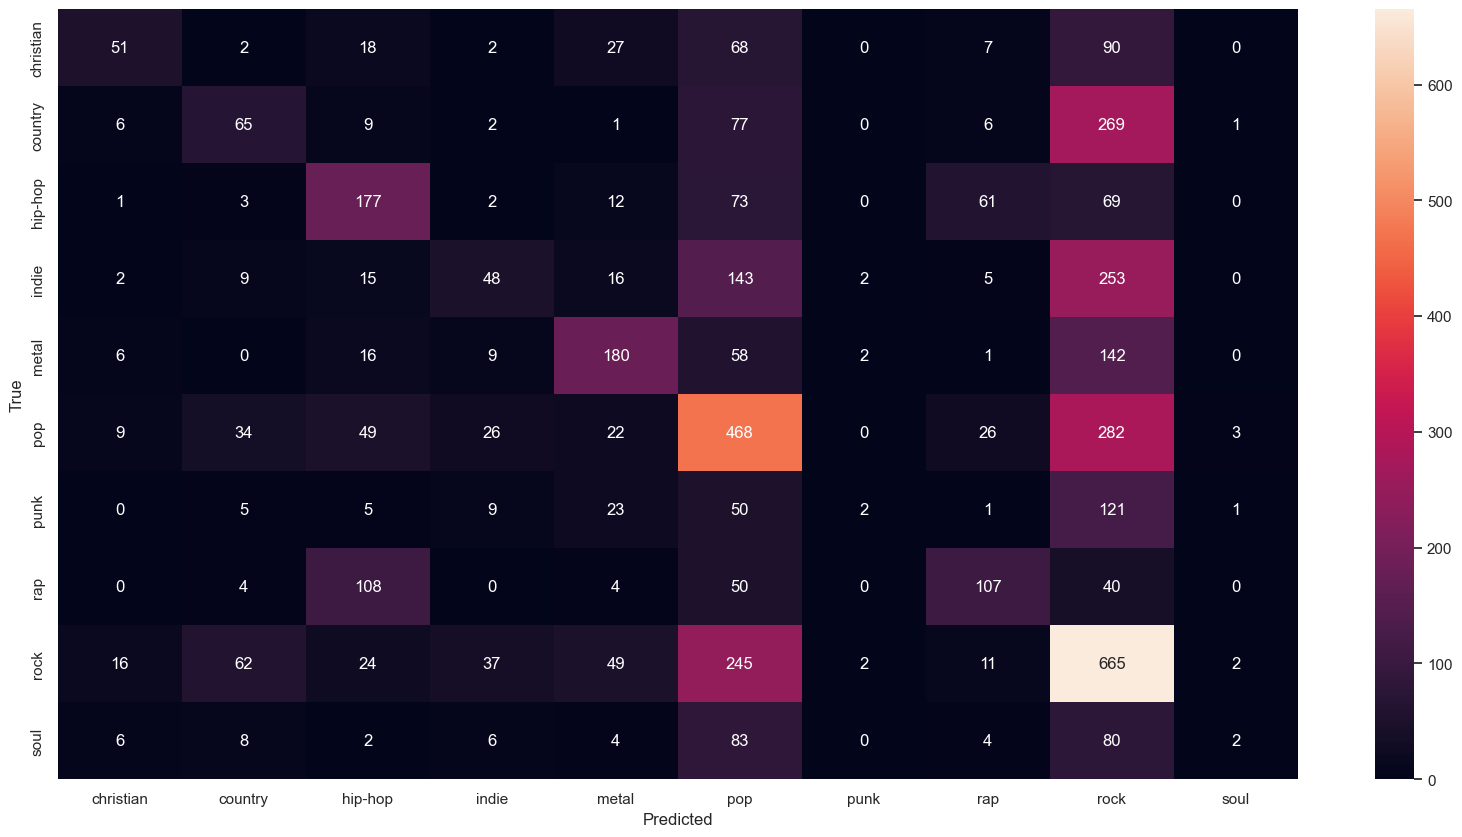

In [11]:
model_name = 'embedding-then-one-layer'
criterion = nn.CrossEntropyLoss()
embedding_then_one_layer_model = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding_then_one_layer")
embedding_then_one_layer_model.to(device)
optimizer = optim.Adam(embedding_then_one_layer_model.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_one_layer_model))
history = train_and_evaluate(embedding_then_one_layer_model, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

# Using lyrics-bert and convolution

Model summary:
---------------------------
Total parameters: 40397342
None
Model embedding-then-conv1d: Epoch: 1 Train Accuracy: 0.2048 Test Accuracy: 0.2337 F1 Score: 0.0885 Train Loss: 0.0060 Test Loss: 0.0045 Train Time/Step: 0.3330 Eval Time/Step: 0.2667
Model embedding-then-conv1d: Epoch: 2 Train Accuracy: 0.2370 Test Accuracy: 0.2337 F1 Score: 0.0885 Train Loss: 0.0042 Test Loss: 0.0044 Train Time/Step: 0.3245 Eval Time/Step: 0.2772
Model embedding-then-conv1d: Epoch: 3 Train Accuracy: 0.2451 Test Accuracy: 0.2530 F1 Score: 0.1408 Train Loss: 0.0042 Test Loss: 0.0043 Train Time/Step: 0.2867 Eval Time/Step: 0.2846
Model embedding-then-conv1d: Epoch: 4 Train Accuracy: 0.2762 Test Accuracy: 0.2763 F1 Score: 0.1560 Train Loss: 0.0040 Test Loss: 0.0041 Train Time/Step: 0.2914 Eval Time/Step: 0.2721
Model embedding-then-conv1d: Epoch: 5 Train Accuracy: 0.3003 Test Accuracy: 0.3200 F1 Score: 0.2287 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.2926 Eval Time/Step: 0.2655
Model

c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   christian       0.91      0.11      0.20       265
     country       0.48      0.12      0.19       436
     hip-hop       0.41      0.66      0.51       398
       indie       0.25      0.02      0.03       493
       metal       0.45      0.55      0.50       414
         pop       0.38      0.31      0.34       919
        punk       0.00      0.00      0.00       217
         rap       0.49      0.19      0.27       313
        rock       0.33      0.75      0.45      1113
        soul       0.00      0.00      0.00       195

    accuracy                           0.37      4763
   macro avg       0.37      0.27      0.25      4763
weighted avg       0.37      0.37      0.31      4763



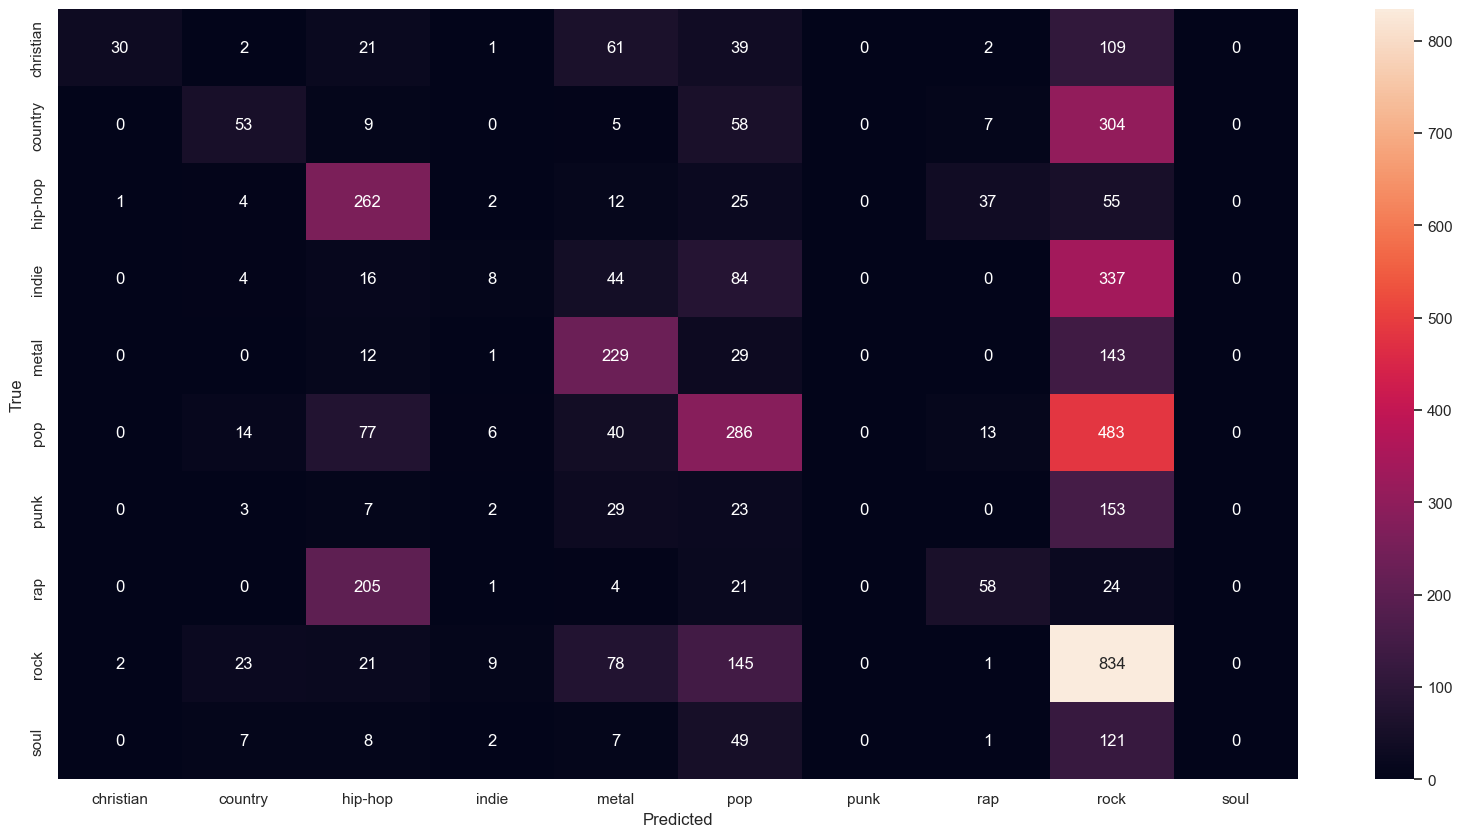

In [12]:
model_name = 'embedding-then-conv1d'
criterion = nn.CrossEntropyLoss()
embedding_then_conv1d = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding-then-conv1d")
embedding_then_conv1d.to(device)
optimizer = optim.Adam(embedding_then_conv1d.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_conv1d))
history = train_and_evaluate(embedding_then_conv1d, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

# Using batch normalization, learning scheduler

Model summary:
---------------------------
Total parameters: 40397342
None
Model embedding-then-conv1d-bn-scheduler: Epoch: 1 Train Accuracy: 0.0864 Test Accuracy: 0.1104 F1 Score: 0.0543 Train Loss: 0.0061 Test Loss: 0.0048 Train Time/Step: 0.3060 Eval Time/Step: 0.2688
Model embedding-then-conv1d-bn-scheduler: Epoch: 2 Train Accuracy: 0.1151 Test Accuracy: 0.1037 F1 Score: 0.0501 Train Loss: 0.0045 Test Loss: 0.0047 Train Time/Step: 0.2888 Eval Time/Step: 0.2578
Model embedding-then-conv1d-bn-scheduler: Epoch: 3 Train Accuracy: 0.1556 Test Accuracy: 0.2480 F1 Score: 0.2179 Train Loss: 0.0044 Test Loss: 0.0045 Train Time/Step: 0.2774 Eval Time/Step: 0.2524
Model embedding-then-conv1d-bn-scheduler: Epoch: 4 Train Accuracy: 0.2000 Test Accuracy: 0.2771 F1 Score: 0.2277 Train Loss: 0.0042 Test Loss: 0.0042 Train Time/Step: 0.2761 Eval Time/Step: 0.2509
Model embedding-then-conv1d-bn-scheduler: Epoch: 5 Train Accuracy: 0.2340 Test Accuracy: 0.2515 F1 Score: 0.2079 Train Loss: 0.0039 Test 

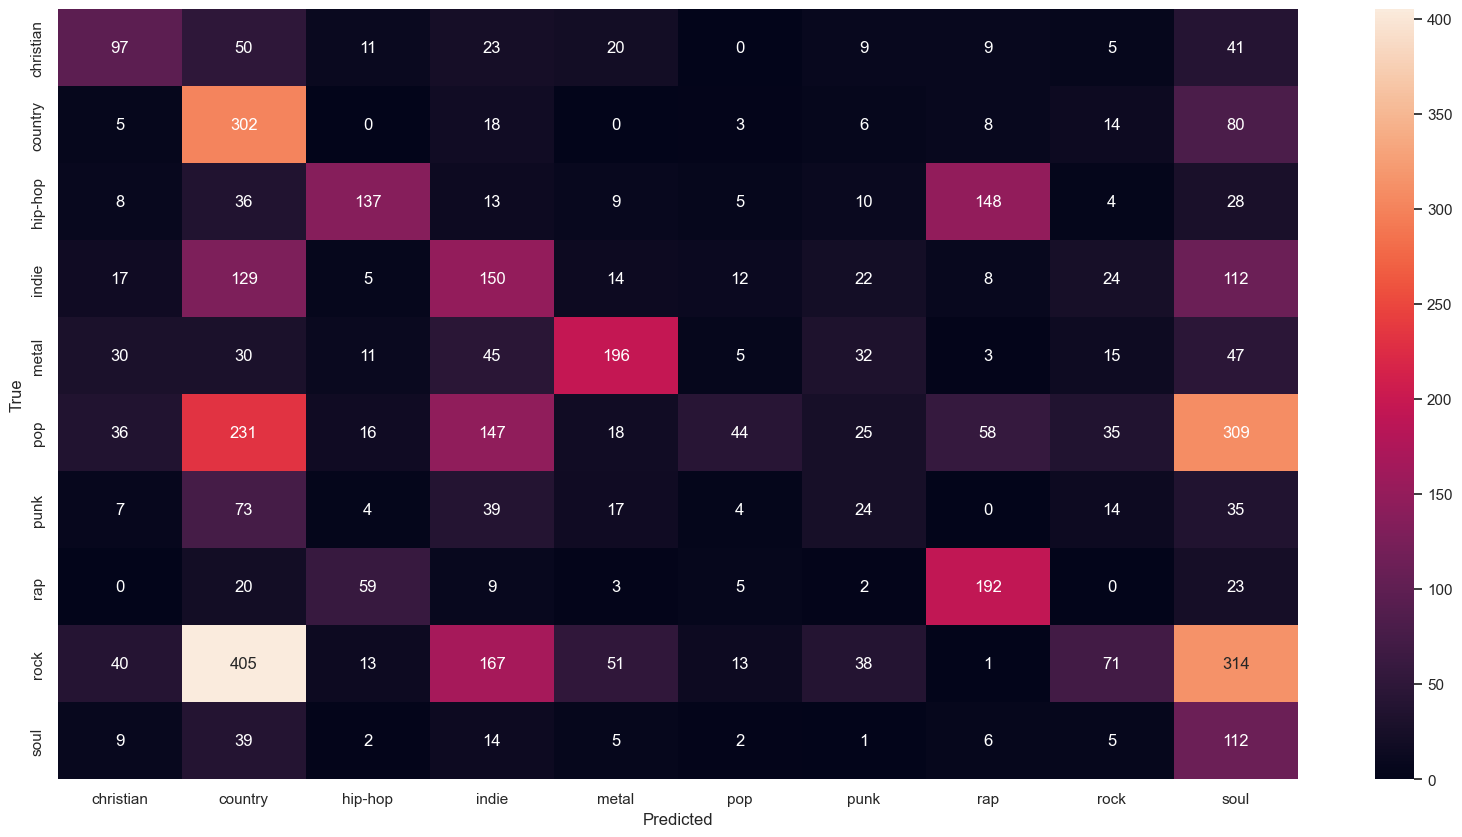

In [13]:
model_name = 'embedding-then-conv1d-bn-scheduler'

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

embedding_then_conv1d_bn_scheduler = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="embedding-then-conv1d")
embedding_then_conv1d_bn_scheduler.to(device)
optimizer = optim.Adam(embedding_then_conv1d_bn_scheduler.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(embedding_then_conv1d_bn_scheduler))
history = train_and_evaluate(embedding_then_conv1d_bn_scheduler, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

# Fully connected layer with batch normalization and learning scheduler

Model summary:
---------------------------
Total parameters: 65550622
None
Model fc-with-batch-normalization: Epoch: 1 Train Accuracy: 0.2457 Test Accuracy: 0.2954 F1 Score: 0.2970 Train Loss: 0.0041 Test Loss: 0.0044 Train Time/Step: 0.2948 Eval Time/Step: 0.2535
Model fc-with-batch-normalization: Epoch: 2 Train Accuracy: 0.3164 Test Accuracy: 0.2958 F1 Score: 0.2848 Train Loss: 0.0038 Test Loss: 0.0042 Train Time/Step: 0.2800 Eval Time/Step: 0.2592
Model fc-with-batch-normalization: Epoch: 3 Train Accuracy: 0.3436 Test Accuracy: 0.3126 F1 Score: 0.3027 Train Loss: 0.0037 Test Loss: 0.0041 Train Time/Step: 0.2841 Eval Time/Step: 0.2519
Model fc-with-batch-normalization: Epoch: 4 Train Accuracy: 0.3884 Test Accuracy: 0.3162 F1 Score: 0.3057 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.2999 Eval Time/Step: 0.2697
Model fc-with-batch-normalization: Epoch: 5 Train Accuracy: 0.4337 Test Accuracy: 0.3303 F1 Score: 0.3197 Train Loss: 0.0036 Test Loss: 0.0041 Train Time/Step: 0.318

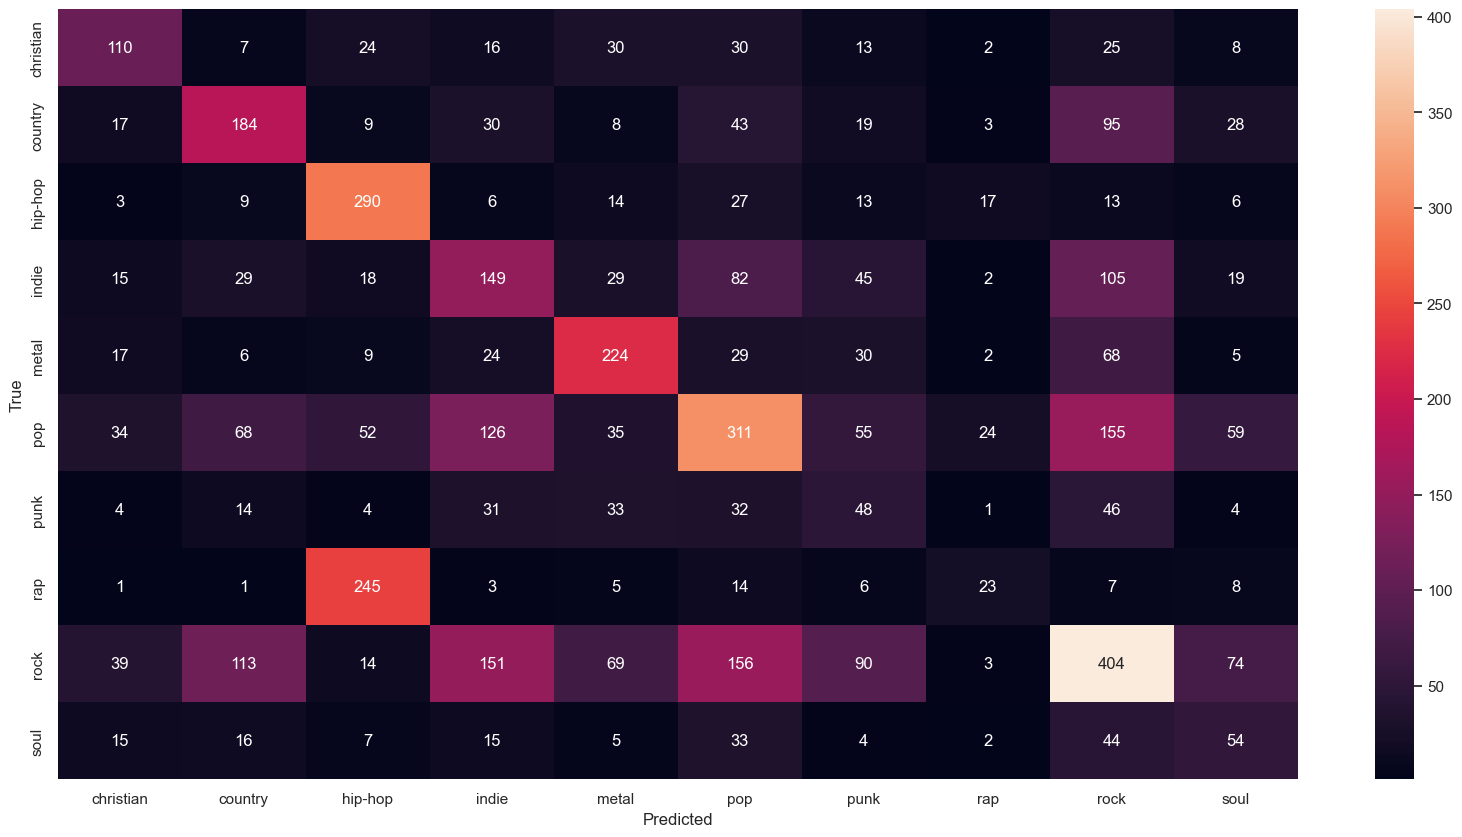

In [14]:
model_name = 'fc-with-batch-normalization'

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

fc_with_batch_normalization = LyricsTextClassificationModel(SentenceTransformer('../models/lyrics-bert/'), 300, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization.to(device)
optimizer = optim.Adam(fc_with_batch_normalization.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization))
history = train_and_evaluate(fc_with_batch_normalization, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

# Same with distilbert base (a bigger, more generally applicable bert model) and let's train for 20 epochs now

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 119792650
None
Model fc-with-batch-normalization-bert-base: Epoch: 1 Train Accuracy: 0.2857 Test Accuracy: 0.3785 F1 Score: 0.3799 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.6844 Eval Time/Step: 1.3138
Model fc-with-batch-normalization-bert-base: Epoch: 2 Train Accuracy: 0.3233 Test Accuracy: 0.3170 F1 Score: 0.2841 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.6690 Eval Time/Step: 1.2934
Model fc-with-batch-normalization-bert-base: Epoch: 3 Train Accuracy: 0.3416 Test Accuracy: 0.3462 F1 Score: 0.3270 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.6637 Eval Time/Step: 1.2912
Model fc-with-batch-normalization-bert-base: Epoch: 4 Train Accuracy: 0.3587 Test Accuracy: 0.3195 F1 Score: 0.2977 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6655 Eval Time/Step: 1.2903
Model fc-with-batch-normalization-bert-base: Epoch: 5 Train Accuracy: 0.3770 Test Accuracy: 0.3368 F1 Score: 0.3182 Train Lo

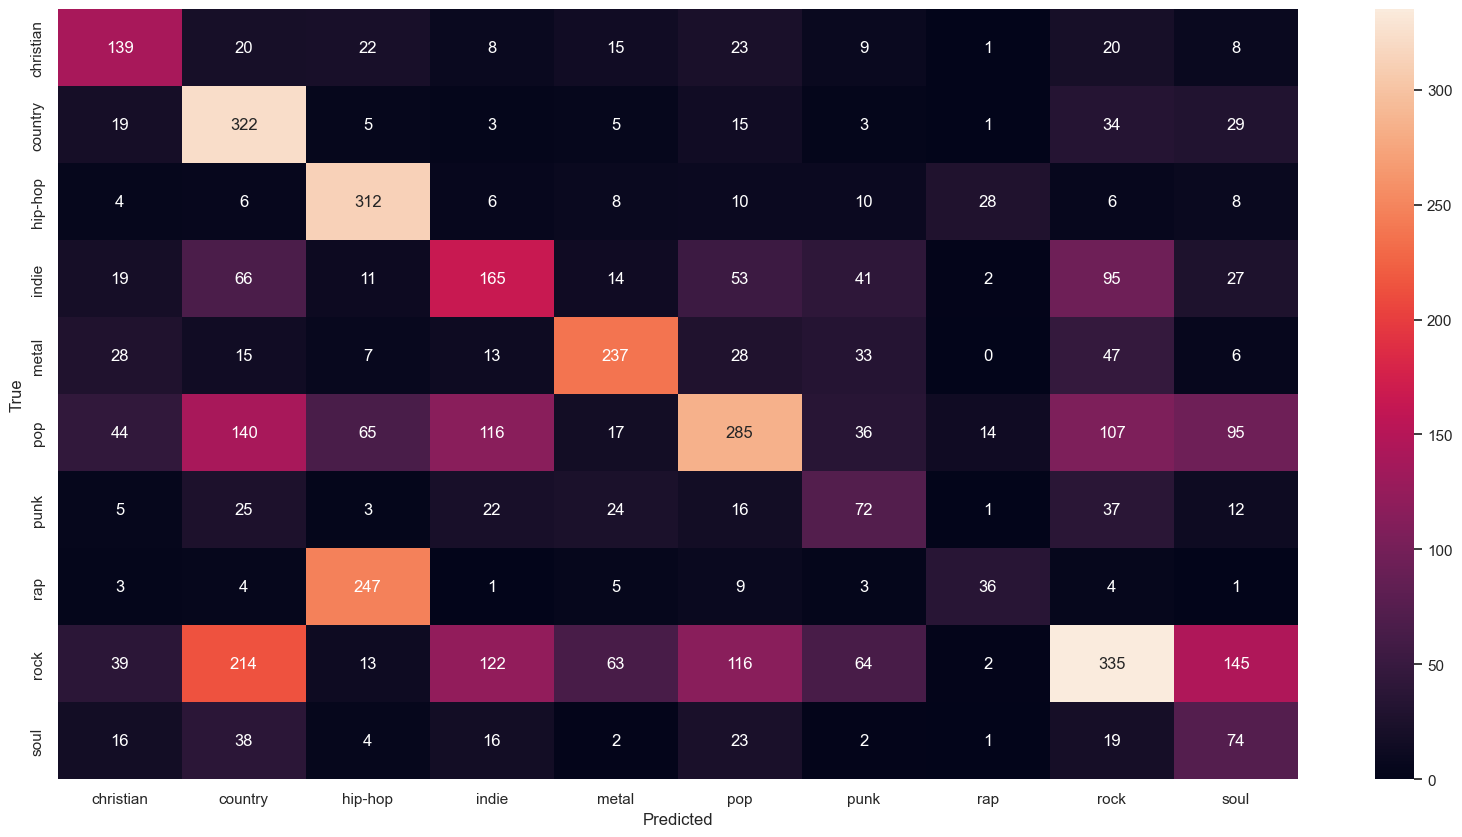

In [15]:
model_name = 'fc-with-batch-normalization-bert-base'

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

fc_with_batch_normalization_bert_base = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="fc-with-batch-normalization", bert_type="distilbert")
fc_with_batch_normalization_bert_base.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_base.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_base))
history = train_and_evaluate(fc_with_batch_normalization_bert_base, model_name, 20, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

In [28]:
model_name = 'embedding-then-conv1d-bn-scheduler-distilbert-base'

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

embedding_then_conv1d_bn_scheduler_distilbert_base = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="embedding-then-conv1d", bert_type="distilbert")
embedding_then_conv1d_bn_scheduler_distilbert_base.to(device)
optimizer = optim.Adam(embedding_then_conv1d_bn_scheduler_distilbert_base.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(embedding_then_conv1d_bn_scheduler_distilbert_base))
history = train_and_evaluate(embedding_then_conv1d_bn_scheduler_distilbert_base, model_name, 20, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 116444426
None


# Using a text data augmentor for augmenting the lyrics

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 119792650
None
Model fc-with-batch-normalization-bert-base-nlpaug: Epoch: 1 Train Accuracy: 0.2917 Test Accuracy: 0.2990 F1 Score: 0.2918 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.6354 Eval Time/Step: 1.3224
Model fc-with-batch-normalization-bert-base-nlpaug: Epoch: 2 Train Accuracy: 0.3287 Test Accuracy: 0.3059 F1 Score: 0.2752 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.6657 Eval Time/Step: 1.2682
Model fc-with-batch-normalization-bert-base-nlpaug: Epoch: 3 Train Accuracy: 0.3472 Test Accuracy: 0.3523 F1 Score: 0.3225 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6704 Eval Time/Step: 1.2926
Model fc-with-batch-normalization-bert-base-nlpaug: Epoch: 4 Train Accuracy: 0.3657 Test Accuracy: 0.3368 F1 Score: 0.3192 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6686 Eval Time/Step: 1.2887
Model fc-with-batch-normalization-bert-base-nlpaug: Epoch: 5 Train Accuracy: 0.3795 Test Accurac

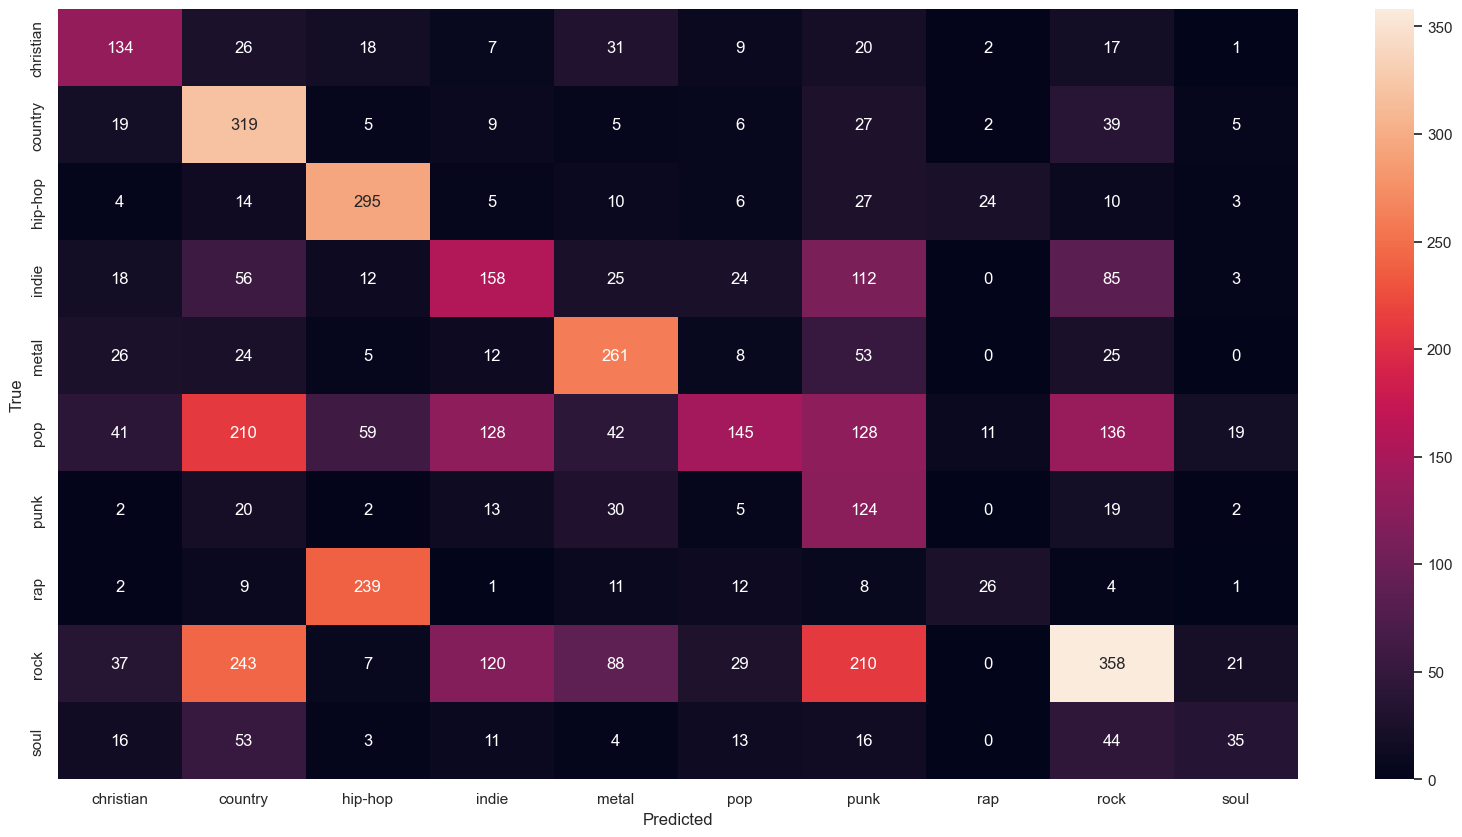

In [16]:
model_name = 'fc-with-batch-normalization-distilbert-base-nlpaug'


train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

fc_with_batch_normalization_bert_base_nlpaug = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="embedding-then-conv1d", bert_type="distilbert")
fc_with_batch_normalization_bert_base_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_base_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_base_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_bert_base_nlpaug, model_name, 10, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Model summary:
---------------------------
Total parameters: 4387210
None
Model embedding-then-one-layer_tiny_bert: Epoch: 1 Train Accuracy: 0.2245 Test Accuracy: 0.2309 F1 Score: 0.1325 Train Loss: 0.0043 Test Loss: 0.0043 Train Time/Step: 0.2998 Eval Time/Step: 0.2917
Model embedding-then-one-layer_tiny_bert: Epoch: 2 Train Accuracy: 0.2645 Test Accuracy: 0.2920 F1 Score: 0.2058 Train Loss: 0.0040 Test Loss: 0.0041 Train Time/Step: 0.3072 Eval Time/Step: 0.2597
Model embedding-then-one-layer_tiny_bert: Epoch: 3 Train Accuracy: 0.3150 Test Accuracy: 0.3250 F1 Score: 0.2418 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.3042 Eval Time/Step: 0.2639
Model embedding-then-one-layer_tiny_bert: Epoch: 4 Train Accuracy: 0.3449 Test Accuracy: 0.3410 F1 Score: 0.2618 Train Loss: 0.0037 Test Loss: 0.0039 Train Time/Step: 0.2942 Eval Time/Step: 0.2599
Model embedding-then-one-layer_tiny_bert: Epoch: 5 Train Accuracy: 0.3564 Test Accuracy: 0.3567 F1 Score: 0.2769 Train Loss: 0.0036 Test L

c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   christian       0.59      0.20      0.30       265
     country       0.50      0.07      0.12       436
     hip-hop       0.45      0.56      0.50       398
       indie       0.31      0.09      0.14       493
       metal       0.56      0.51      0.53       414
         pop       0.34      0.52      0.41       919
        punk       0.00      0.00      0.00       217
         rap       0.51      0.30      0.38       313
        rock       0.35      0.62      0.44      1113
        soul       0.00      0.00      0.00       195

    accuracy                           0.38      4763
   macro avg       0.36      0.29      0.28      4763
weighted avg       0.38      0.38      0.34      4763



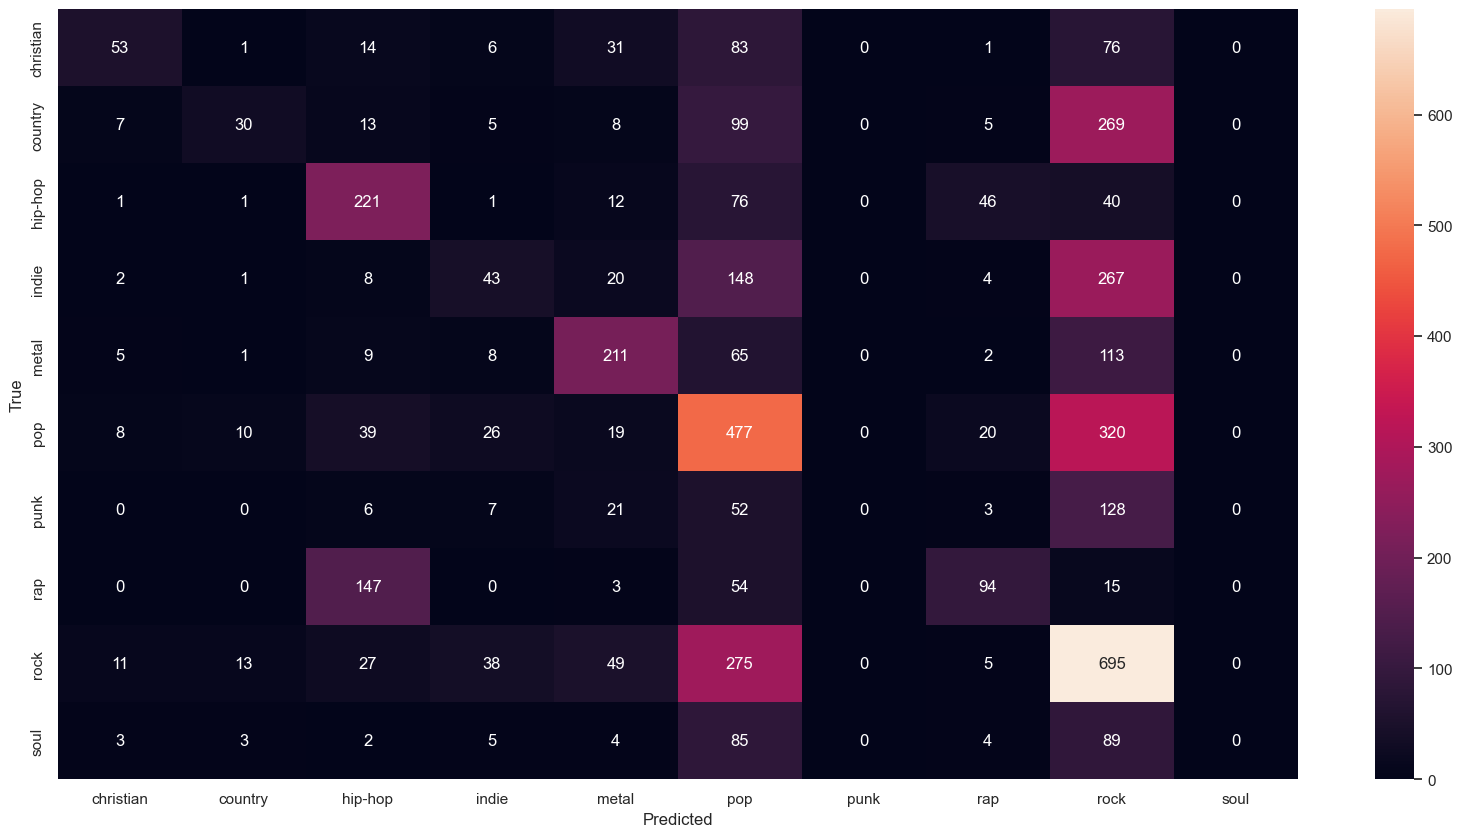

In [17]:
model_name = 'embedding-then-one-layer_tiny_bert'
criterion = nn.CrossEntropyLoss()
embedding_then_one_layer_model_tiny_bert = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="embedding_then_one_layer")
embedding_then_one_layer_model_tiny_bert.to(device)
optimizer = optim.Adam(embedding_then_one_layer_model_tiny_bert.parameters(), lr=learning_rate) 
print(model_summary(embedding_then_one_layer_model_tiny_bert))
history = train_and_evaluate(embedding_then_one_layer_model_tiny_bert, model_name, 10, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Model summary:
---------------------------
Total parameters: 45691530
None
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 1 Train Accuracy: 0.2431 Test Accuracy: 0.2992 F1 Score: 0.2873 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.2903 Eval Time/Step: 0.2535
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 2 Train Accuracy: 0.2851 Test Accuracy: 0.2803 F1 Score: 0.2668 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.2846 Eval Time/Step: 0.2501
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 3 Train Accuracy: 0.2906 Test Accuracy: 0.2769 F1 Score: 0.2585 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.2922 Eval Time/Step: 0.2527
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 4 Train Accuracy: 0.2980 Test Accuracy: 0.2853 F1 Score: 0.2690 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.2887 Eval Time/Step: 0.2510
Model fc-with-batch-normalization-bert-tiny-nlpaug: Epoch: 5 Train Accuracy: 0.3084 Test Accuracy

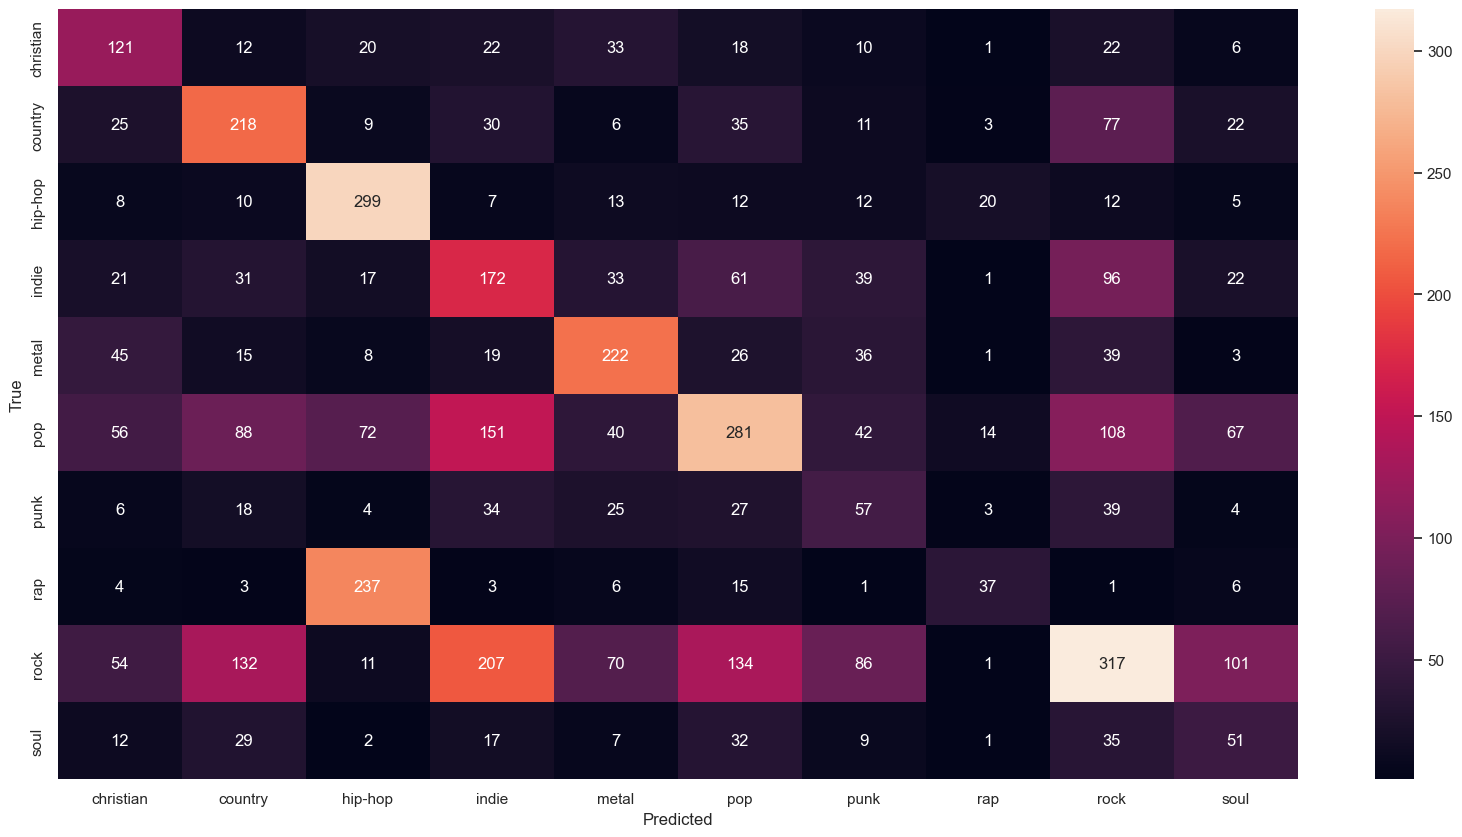

In [18]:
model_name = 'fc-with-batch-normalization-bert-tiny-nlpaug'

train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

fc_with_batch_normalization_bert_tiny_nlpaug = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization_bert_tiny_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_tiny_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_tiny_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_bert_tiny_nlpaug, model_name, 25, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

No sentence-transformers model found with name C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\bruno/.cache\torch\sentence_transformers\prajjwal1_bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Model summary:
---------------------------
Total parameters: 45691530
None
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 1 Train Accuracy: 0.2531 Test Accuracy: 0.3153 F1 Score: 0.3080 Train Loss: 0.0040 Test Loss: 0.0042 Train Time/Step: 0.3208 Eval Time/Step: 0.2860
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 2 Train Accuracy: 0.2853 Test Accuracy: 0.2897 F1 Score: 0.2641 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.3121 Eval Time/Step: 0.2679
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 3 Train Accuracy: 0.3011 Test Accuracy: 0.3153 F1 Score: 0.2961 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.3019 Eval Time/Step: 0.2664
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 4 Train Accuracy: 0.3050 Test Accuracy: 0.3158 F1 Score: 0.2985 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.2997 Eval Time/Step: 0.2610
Model fc-with-batch-normalization-st5-xxl-nlpaug: Epoch: 5 Train Accuracy: 0.3206 Test Accuracy: 0.3265 F

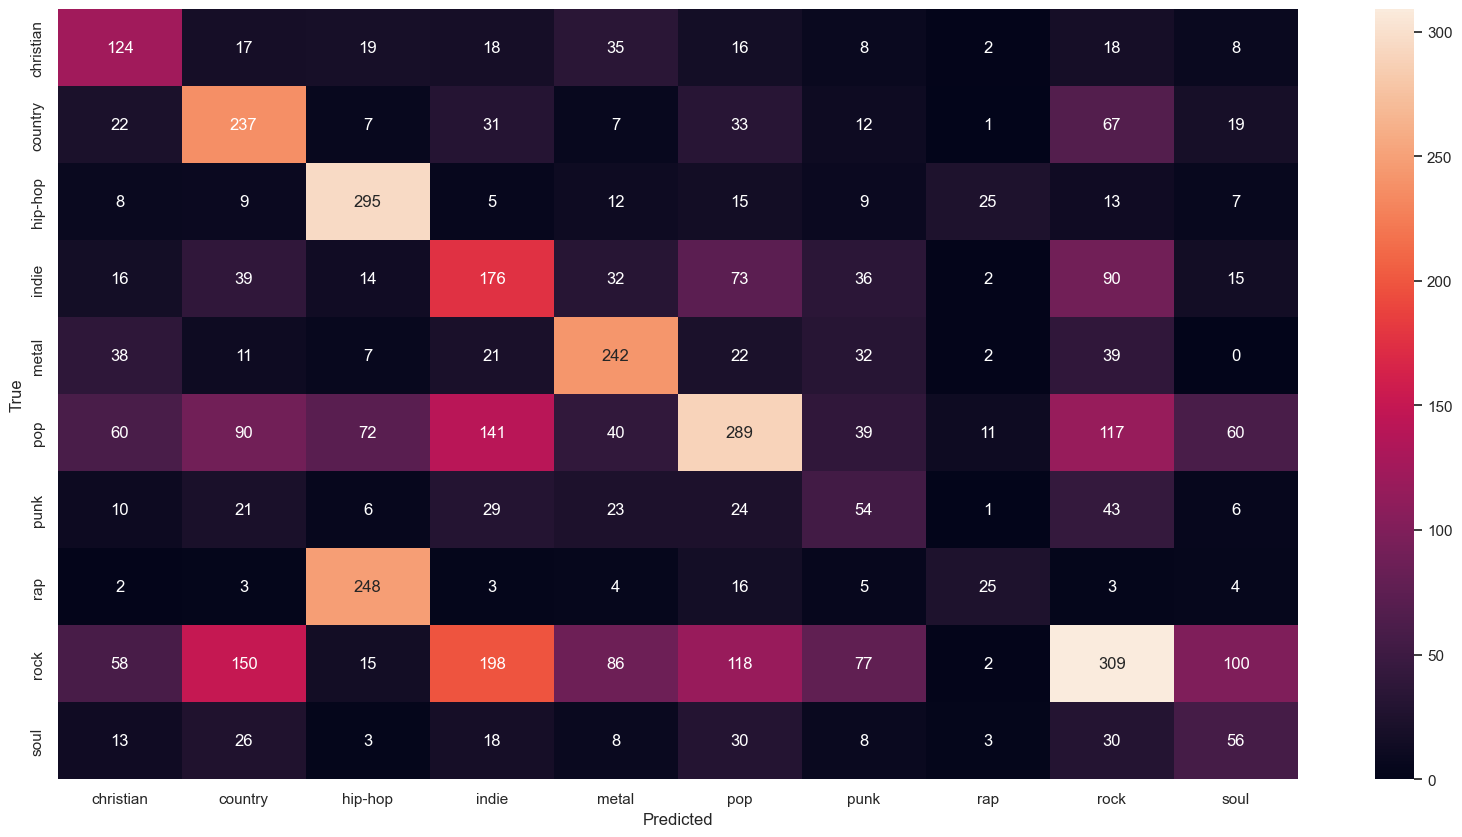

In [19]:
model_name = 'fc-with-batch-normalization-st5-xxl-nlpaug'


train_dataset_nlpaug = LyricsDataset(train_features, train_targets, augment=True)
train_dataloader_nlpaug = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

fc_with_batch_normalization_st5_xxl_nlpaug = LyricsTextClassificationModel(SentenceTransformer("prajjwal1/bert-tiny"), 128, categories, model_type="fc-with-batch-normalization")
fc_with_batch_normalization_st5_xxl_nlpaug.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_st5_xxl_nlpaug.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_st5_xxl_nlpaug))
history = train_and_evaluate(fc_with_batch_normalization_st5_xxl_nlpaug, model_name, 25, criterion, optimizer, train_dataloader_nlpaug, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

Model summary:
---------------------------
Total parameters: 20986644


c:\Users\bruno\.conda\envs\my_env\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 19052, number of used features: 300
[LightGBM] [Info] Start training from score -2.943180
[LightGBM] [Info] Start training from score -2.393287
[LightGBM] [Info] Start training from score -2.443371
[LightGBM] [Info] Start training from score -2.278830
[LightGBM] [Info] Start training from score -2.524522
[LightGBM] [Info] Start training from score -1.631837
[LightGBM] [Info] Start training from score -3.092198
[LightGBM] [Info] Start training from score -2.656744
[LightGBM] [Info] Start training from score -1.438439
[LightGBM] [Info] Start training from score -3.266001
[1]	valid_0's multi_logloss: 2.10195
Training until validation scores don't improve for 25 rounds
[2]	valid_0's multi_logloss: 2.06762
[3]	valid_0's multi_logloss: 2.

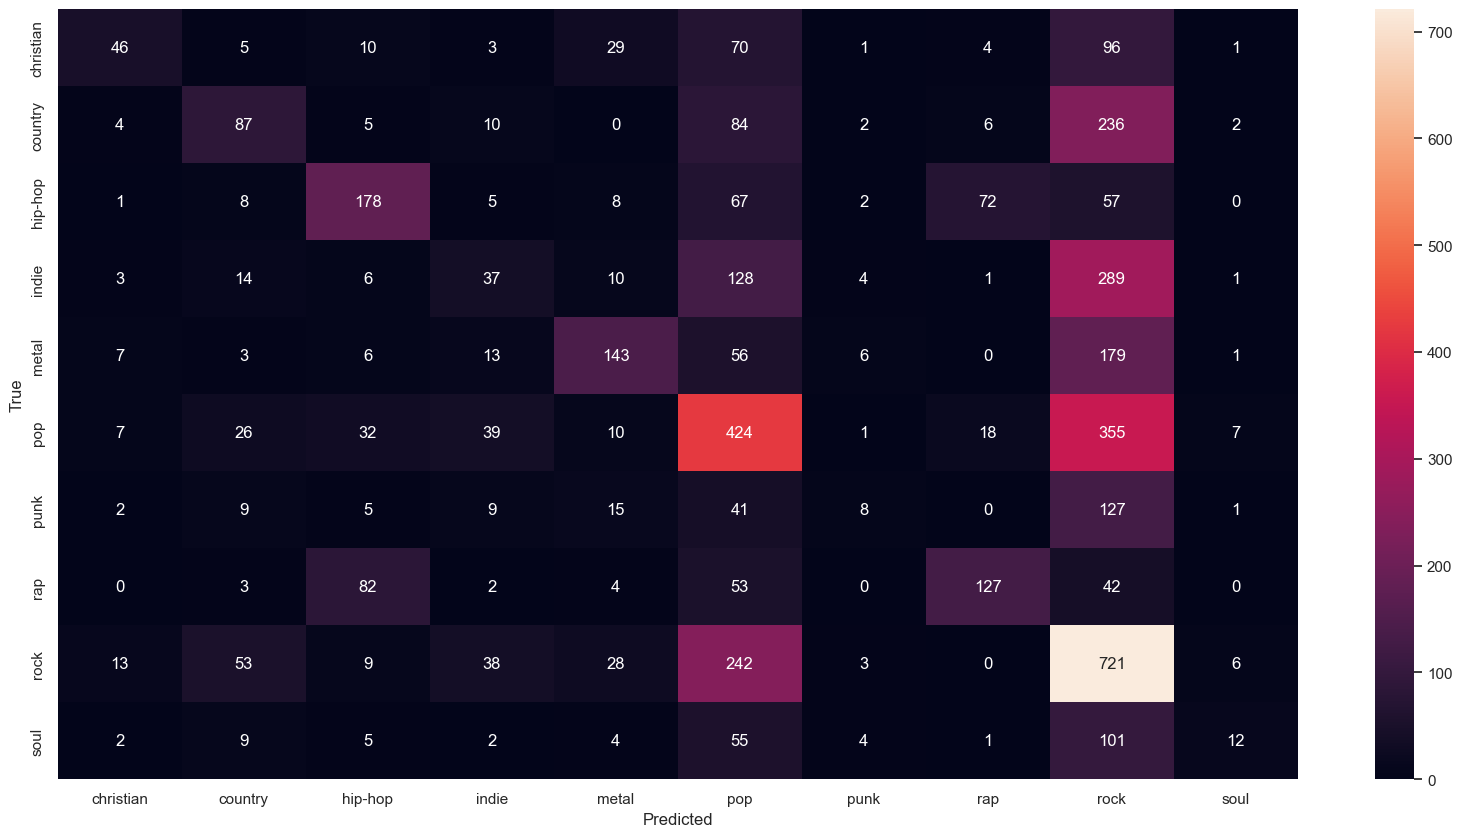

In [21]:
import lightgbm as lgb

class BertFeatureExtractor(torch.nn.Module):
    def __init__(self, embedding_model):
        super(BertFeatureExtractor, self).__init__()
        self.embedding_model = embedding_model
    
    def forward(self, x):
        x = self.embedding_model.encode(x, convert_to_tensor=True)
        return x

# Initialize BERT feature extractor
bert_extractor = BertFeatureExtractor(SentenceTransformer('../models/lyrics-bert/'))
bert_extractor.to(device)
model_summary(bert_extractor)

train_features_lgb = []
train_targets_lgb = []
for inputs, labels in train_dataloader:
    outputs = bert_extractor(inputs)
    train_features_lgb.append(outputs.detach().cpu().numpy())
    train_targets_lgb.append(labels.detach().cpu().numpy())
train_features_lgb = np.vstack(train_features_lgb)
train_targets_lgb = np.array([item for sublist in train_targets_lgb for item in sublist])

# Generate features for training data
test_features_lgb = []
test_targets_lgb = []
for inputs, labels in test_dataloader:
    outputs = bert_extractor(inputs)
    test_features_lgb.append(outputs.detach().cpu().numpy())
    test_targets_lgb.append(labels.detach().cpu().numpy())
test_features_lgb = np.vstack(test_features_lgb)
test_targets_lgb = np.array([item for sublist in test_targets_lgb for item in sublist])

# Train LightGBM model on generated features
train_data_lgb = lgb.Dataset(train_features_lgb, label=train_targets_lgb)
test_data_lgb = lgb.Dataset(test_features_lgb, label=test_targets_lgb)
params = {'objective': 'multiclass', 'num_class': len(categories), 'metric': 'multi_logloss'}
model = lgb.train(params, train_data_lgb, num_boost_round=1000, valid_sets=[test_data_lgb], early_stopping_rounds=25)

# Evaluate LightGBM model on test data
y_pred = model.predict(test_features_lgb)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_targets_lgb, y_pred)
report = classification_report(test_targets_lgb, y_pred, target_names=categories)
print(report)
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()